In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/land-cover-classification-master')

In [ ]:
!pip install tensorflow rasterio numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 95.9 MB/s eta 0:00:00


### Training without using pre trained weights

In [ ]:
import numpy as np
import rasterio  # For reading .tif images
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Define dataset file paths
dataset_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3.tif"
ground_truth_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3_gr.tif"

# 🔹 **1️⃣ Load Hyperspectral Image**
with rasterio.open(dataset_path) as src:
    image = src.read()  # Shape: (220, H, W)

# Load Ground Truth Labels
with rasterio.open(ground_truth_path) as src:
    labels = src.read(1)  # Shape: (H, W)

# Transpose image from (Bands, Height, Width) → (Height, Width, Bands)
image = np.transpose(image, (1, 2, 0))  # Shape: (H, W, 220)

# 🔹 **2️⃣ Check Unique Labels in Ground Truth**
unique_labels = np.unique(labels)
print("Unique label values in dataset:", unique_labels)

if len(unique_labels) <= 1:
    raise ValueError("Error: Only one or no valid class labels found in the dataset!")

# 🔹 **3️⃣ Normalize the Image (MinMax Scaling)**
def normalize_image(image):
    scaler = MinMaxScaler()
    h, w, bands = image.shape
    image = image.reshape(-1, bands)  # Flatten to (pixels, bands)
    image = scaler.fit_transform(image)  # Normalize
    return image.reshape(h, w, bands)  # Reshape back

image = normalize_image(image)

# 🔹 **4️⃣ Apply PCA (Reduce from 220 Bands → 50 Bands)**
def apply_pca(image, num_components=50):
    h, w, bands = image.shape
    image_reshaped = image.reshape(-1, bands)  # Flatten to (pixels, bands)
    pca = PCA(n_components=num_components)
    image_pca = pca.fit_transform(image_reshaped)
    return image_pca.reshape(h, w, num_components)  # Reshape back

NUM_COMPONENTS = 50
image = apply_pca(image, num_components=NUM_COMPONENTS)

# 🔹 **5️⃣ Extract Patches for CNN Input**
PATCH_SIZE = 32  # Must match input size in the model

def extract_patches(image, labels, patch_size):
    half_patch = patch_size // 2
    h, w, bands = image.shape
    X, y = [], []

    for i in range(half_patch, h - half_patch):
        for j in range(half_patch, w - half_patch):
            if labels[i, j] > 0:  # Ignore background pixels (0)
                patch = image[i - half_patch:i + half_patch, j - half_patch:j + half_patch, :]
                if patch.shape == (patch_size, patch_size, bands):  # Ensure valid shape
                    X.append(patch)
                    y.append(labels[i, j] - 1)  # Adjust class labels to start from 0

    print(f"Total patches extracted: {len(X)}")  # Debugging output

    if len(X) == 0:
        raise ValueError("No valid patches extracted! Check dataset and preprocessing.")

    return np.array(X), np.array(y)

X, y = extract_patches(image, labels, PATCH_SIZE)

# 🔹 **6️⃣ Convert Labels to One-Hot Encoding**
NUM_CLASSES = 17
y = to_categorical(y, NUM_CLASSES)

# 🔹 **7️⃣ Split into Train & Validation Sets**
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🔹 **8️⃣ Print Shapes for Verification**
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Unique label values in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Total patches extracted: 7317
Train shape: (5853, 32, 32, 50), Validation shape: (1464, 32, 32, 50)


In [ ]:
from LULC_CNN_VGG16 import LULC_VGG16

# Ensure dataset preprocessing is updated
PATCH_SIZE = 32
nn_vgg16 = LULC_VGG16(input_shape=(PATCH_SIZE, PATCH_SIZE, 50),
                       n_classes=17,
                       learning_rate=0.001,
                       dropout_rate=0.3,
                       epochs=50,
                       batch_size=16)

# Train the model
history_vgg16 = nn_vgg16.fit(X_train, y_train, X_val, y_val)

Epoch 1/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.2621 - loss: 2.3258 - val_accuracy: 0.2917 - val_loss: 2.1687
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.2872 - loss: 2.1738 - val_accuracy: 0.2917 - val_loss: 2.1589
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.2943 - loss: 2.1725 - val_accuracy: 0.2917 - val_loss: 2.1574
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.3036 - loss: 2.1330 - val_accuracy: 0.2917 - val_loss: 2.1590
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.2860 - loss: 2.1629 - val_accuracy: 0.2917 - val_loss: 2.1577
Epoch 6/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.2922 - loss: 2.1913 - val_accuracy: 0.2917 - val_loss: 2.1542
Epoch 7/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.3021 - loss: 2.1587 - val_accuracy: 0.2917 - val_loss: 2.1565
Epoch 8/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.2813 - loss: 2.1580 - 

### Training using pre trained weights from "Imagenet"

In [ ]:
import numpy as np
import rasterio  # For reading .tif images
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Define dataset file paths
dataset_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3.tif"
ground_truth_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3_gr.tif"

# 🔹 **1️⃣ Load Hyperspectral Image**
with rasterio.open(dataset_path) as src:
    image = src.read()  # Shape: (220, H, W)

# Load Ground Truth Labels
with rasterio.open(ground_truth_path) as src:
    labels = src.read(1)  # Shape: (H, W)

# Transpose image from (Bands, Height, Width) → (Height, Width, Bands)
image = np.transpose(image, (1, 2, 0))  # Shape: (H, W, 220)

# 🔹 **2️⃣ Check Unique Labels in Ground Truth**
unique_labels = np.unique(labels)
print("Unique label values in dataset:", unique_labels)

if len(unique_labels) <= 1:
    raise ValueError("Error: Only one or no valid class labels found in the dataset!")

# 🔹 **3️⃣ Normalize the Image (MinMax Scaling)**
def normalize_image(image):
    scaler = MinMaxScaler()
    h, w, bands = image.shape
    image = image.reshape(-1, bands)  # Flatten to (pixels, bands)
    image = scaler.fit_transform(image)  # Normalize
    return image.reshape(h, w, bands)  # Reshape back

image = normalize_image(image)

# 🔹 **4️⃣ Apply PCA (Reduce from 220 Bands → 50 Bands)**
def apply_pca(image, num_components=50):
    h, w, bands = image.shape
    image_reshaped = image.reshape(-1, bands)  # Flatten to (pixels, bands)
    pca = PCA(n_components=num_components)
    image_pca = pca.fit_transform(image_reshaped)
    return image_pca.reshape(h, w, num_components)  # Reshape back

NUM_COMPONENTS = 50
image = apply_pca(image, num_components=NUM_COMPONENTS)

# 🔹 **5️⃣ Extract Patches for CNN Input**
PATCH_SIZE = 32  # Must match input size in the model

def extract_patches(image, labels, patch_size):
    half_patch = patch_size // 2
    h, w, bands = image.shape
    X, y = [], []

    for i in range(half_patch, h - half_patch):
        for j in range(half_patch, w - half_patch):
            if labels[i, j] > 0:  # Ignore background pixels (0)
                patch = image[i - half_patch:i + half_patch, j - half_patch:j + half_patch, :]
                if patch.shape == (patch_size, patch_size, bands):  # Ensure valid shape
                    X.append(patch)
                    y.append(labels[i, j] - 1)  # Adjust class labels to start from 0

    print(f"Total patches extracted: {len(X)}")  # Debugging output

    if len(X) == 0:
        raise ValueError("No valid patches extracted! Check dataset and preprocessing.")

    return np.array(X), np.array(y)

X, y = extract_patches(image, labels, PATCH_SIZE)

# 🔹 **6️⃣ Convert Labels to One-Hot Encoding**
NUM_CLASSES = 17
y = to_categorical(y, NUM_CLASSES)

# 🔹 **7️⃣ Split into Train & Validation Sets**
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🔹 **8️⃣ Print Shapes for Verification**
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Unique label values in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Total patches extracted: 7317
Train shape: (5853, 32, 32, 50), Validation shape: (1464, 32, 32, 50)


# Fresh start


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Create directory for saving the best model
os.makedirs("checkpoints", exist_ok=True)

# Load VGG16 with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers to retain learned features
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(17, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 14,850,385 (56.65 MB)

 Trainable params: 135,697 (530.07 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# 📦 Imports
import numpy as np
import rasterio
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from skimage.transform import resize
import os

# 📁 Paths
dataset_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3.tif"
ground_truth_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3_gr.tif"

# 📥 Load Hyperspectral Image
with rasterio.open(dataset_path) as src:
    image = src.read()  # (220, H, W)
image = np.transpose(image, (1, 2, 0))  # (H, W, 220)

# 📥 Load Labels
with rasterio.open(ground_truth_path) as src:
    labels = src.read(1)  # (H, W)

# ⚙️ Normalize
def normalize_image(image):
    h, w, bands = image.shape
    image_flat = image.reshape(-1, bands)
    image_scaled = MinMaxScaler().fit_transform(image_flat)
    return image_scaled.reshape(h, w, bands)

image = normalize_image(image)

# ⚙️ PCA: 220 → 3 channels for VGG16
def apply_pca(image, n_components=3):
    h, w, bands = image.shape
    image_reshaped = image.reshape(-1, bands)
    pca = PCA(n_components=n_components)
    image_pca = pca.fit_transform(image_reshaped)
    return image_pca.reshape(h, w, n_components)

image = apply_pca(image)

# 📦 Extract Patches
PATCH_SIZE = 15

def extract_patches(image, labels, patch_size):
    half = patch_size // 2
    h, w, bands = image.shape
    X, y, coords = [], [], []

    for i in range(half, h - half):
        for j in range(half, w - half):
            label = labels[i, j]
            if label > 0:
                patch = image[i - half:i + half + 1, j - half:j + half + 1, :]
                if patch.shape == (patch_size, patch_size, bands):
                    X.append(patch)
                    y.append(label - 1)
                    coords.append((i, j))

    print("✅ Total valid patches extracted:", len(X))
    return np.array(X), np.array(y), coords

X, y, coords = extract_patches(image, labels, PATCH_SIZE)

# 🔢 One-hot Encode Labels
NUM_CLASSES = len(np.unique(y))
y = to_categorical(y, NUM_CLASSES)

# 🔀 Train-Val-Test Split
X_temp, X_test, y_temp, y_test, coords_temp, coords_test = train_test_split(
    X, y, coords, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)
coords_train, coords_val = train_test_split(coords_temp, test_size=0.1765, random_state=42)

# 💾 Save test data
with open("/content/drive/MyDrive/land-cover-classification-master/test_data_vgg16.pkl", "wb") as f:
    pickle.dump((X_test, y_test), f)

with open("/content/drive/MyDrive/land-cover-classification-master/coords_test_vgg16.pkl", "wb") as f:
    pickle.dump(coords_test, f)

# ⚙️ Patch Generator with Augmentation & On-the-Fly Resizing
class PatchGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, augment=False, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        ) if augment else None
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = np.array([resize(self.X[i], (224, 224), preserve_range=True) for i in batch_indices])
        y_batch = self.y[batch_indices]
        if self.augment:
            X_batch = next(self.datagen.flow(X_batch, batch_size=len(X_batch), shuffle=False))
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# 📈 Model Definition using VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 🎯 Training
train_gen = PatchGenerator(X_train, y_train, batch_size=32, augment=True)
val_gen = PatchGenerator(X_val, y_val, batch_size=32, augment=False)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


✅ Total valid patches extracted: 9427


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 203s 902ms/step - accuracy: 0.4023 - loss: 1.8320 - val_accuracy: 0.7385 - val_loss: 0.8848
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 178s 858ms/step - accuracy: 0.6952 - loss: 0.9421 - val_accuracy: 0.8466 - val_loss: 0.6271
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 179s 867ms/step - accuracy: 0.7796 - loss: 0.7106 - val_accuracy: 0.8813 - val_loss: 0.4984
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 177s 852ms/step - accuracy: 0.8309 - loss: 0.5616 - val_accuracy: 0.8947 - val_loss: 0.3983
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 179s 866ms/step - accuracy: 0.8473 - loss: 0.4943 - val_accuracy: 0.9230 - val_loss: 0.3144
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 177s 857ms/step - accuracy: 0.8829 - loss: 0.4188 - val_accuracy: 0.9343 - val_loss: 0.2665
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 177s 853ms/step - accuracy: 0.8815 - loss: 0.3796 - val_accuracy: 0.9413 - val_loss: 0.2337
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 175s 844ms/step - accuracy: 0.9062 -

In [ ]:
model.save("/content/drive/MyDrive/land-cover-classification-master/vgg16_updated_model.h5")

Original test shape: (1415, 15, 15, 3)
Resized test shape: (1415, 224, 224, 3)


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 286ms/step

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      0.99      0.99       212
           2       0.99      1.00      0.99        93
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        60
           5       0.99      1.00      1.00       112
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00        66
           8       1.00      0.67      0.80         3
           9       0.99      0.99      0.99       132
          10       0.99      0.99      0.99       348
          11       1.00      0.99      0.99        82
          12       1.00      1.00      1.00        32
          13       1.00      1.00      1.00       188
          14       0.97      1.00      0.98        31
          15       1.00      1.00      1.00        14

    accuracy 

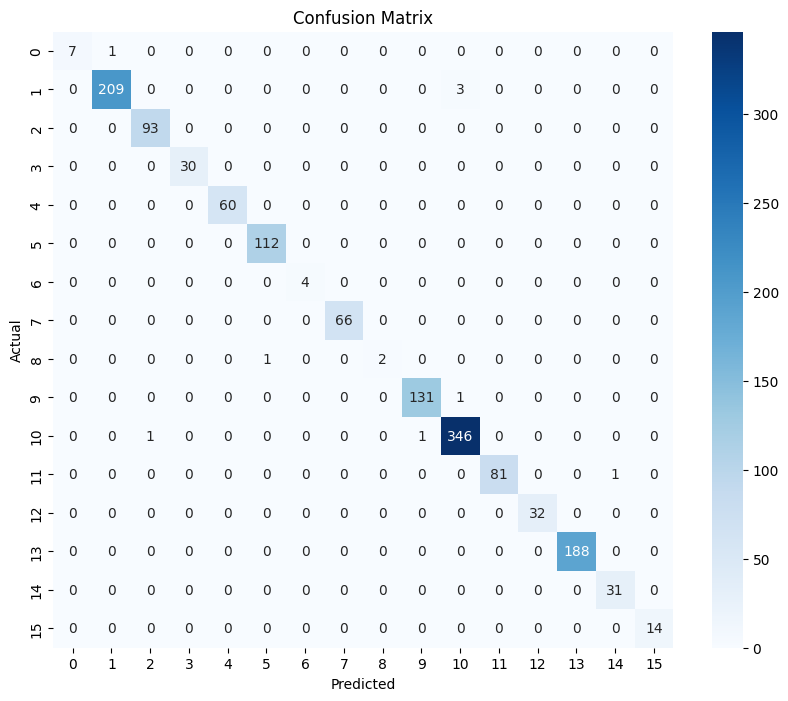

In [ ]:
import pickle
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# --- Step 1: Load test data ---
with open('/content/drive/MyDrive/land-cover-classification-master/test_data_vgg16.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

print(f"Original test shape: {X_test.shape}")

# --- Step 2: Resize patches to 224x224x3 ---
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
print(f"Resized test shape: {X_test_resized.shape}")

# --- Step 3: Load the trained model ---
model = load_model('/content/drive/MyDrive/land-cover-classification-master/vgg16_updated_model.h5')  # Replace with actual path

# --- Step 4: Make predictions ---
y_pred_probs = model.predict(X_test_resized)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # assuming one-hot encoded

# --- Step 5: Evaluation ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

print(f"\nAccuracy Score: {accuracy_score(y_true, y_pred):.4f}")

# --- Step 6: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report_dict = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

              precision    recall  f1-score     support
0              1.000000  0.875000  0.933333     8.00000
1              0.995238  0.985849  0.990521   212.00000
2              0.989362  1.000000  0.994652    93.00000
3              1.000000  1.000000  1.000000    30.00000
4              1.000000  1.000000  1.000000    60.00000
5              0.991150  1.000000  0.995556   112.00000
6              1.000000  1.000000  1.000000     4.00000
7              1.000000  1.000000  1.000000    66.00000
8              1.000000  0.666667  0.800000     3.00000
9              0.992424  0.992424  0.992424   132.00000
10             0.988571  0.994253  0.991404   348.00000
11             1.000000  0.987805  0.993865    82.00000
12             1.000000  1.000000  1.000000    32.00000
13             1.000000  1.000000  1.000000   188.00000
14             0.968750  1.000000  0.984127    31.00000
15             1.000000  1.000000  1.000000    14.00000
accuracy       0.993640  0.993640  0.993640     